In [2]:
import os

from dotenv import load_dotenv

load_dotenv(os.path.join("..", ".env"), override=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Agent for Research

Now, we can put everything we have learned together. 

* We will use **TODOs** to keep track of tasks. 
* We will use **files** to store raw tool call results. 
* We will **delegate research tasks to sub-agents** for context isolation. 

We can simply use the existing instructions that we've built up! 

In [ ]:
from datetime import datetime

from IPython.display import Image, display
from langchain.chat_models import init_chat_model
from langgraph.prebuilt import create_react_agent
from utils import show_prompt

from deep_agents_from_scratch.file_tools import ls, read_file, write_file
from deep_agents_from_scratch.prompts import (
    FILE_USAGE_INSTRUCTIONS,
    RESEARCHER_INSTRUCTIONS,
    SUBAGENT_USAGE_INSTRUCTIONS,
    TODO_USAGE_INSTRUCTIONS,
)
from deep_agents_from_scratch.research_tools import tavily_search, think_tool
from deep_agents_from_scratch.state import DeepAgentState
from deep_agents_from_scratch.task_tool import _create_task_tool
from deep_agents_from_scratch.todo_tool import write_todos

# Create agent using create_react_agent directly
model = init_chat_model(model="anthropic:claude-sonnet-4-20250514", temperature=0.0)

# Limits 
max_concurrent_research_units = 3 
max_researcher_iterations = 3

# Tools 
sub_agent_tools = [tavily_search, think_tool]
built_in_tools = [ls, read_file, write_file, write_todos, think_tool]

# Create research sub-agent
research_sub_agent = {
    "name": "research-agent",
    "description": "Delegate research to the sub-agent researcher. Only give this researcher one topic at a time.",
    "prompt": RESEARCHER_INSTRUCTIONS,
    "tools": ["tavily_search", "think_tool"] 
}

# Create task tool to delegate tasks to sub-agents
task_tool = _create_task_tool(
    sub_agent_tools,
    [research_sub_agent],
    model,
    DeepAgentState
)

delegation_tools = [task_tool] 
all_tools = sub_agent_tools + built_in_tools + delegation_tools

# Build prompt 
SUBAGENT_INSTRUCTIONS = SUBAGENT_USAGE_INSTRUCTIONS.format(
        max_concurrent_research_units=max_concurrent_research_units,
        max_researcher_iterations=max_researcher_iterations,
        date=datetime.now().strftime("%a %b %-d, %Y") 
    )

In [ ]:
INSTRUCTIONS = (
    "# TODO MANAGEMENT\n" + TODO_USAGE_INSTRUCTIONS + 
    "\n\n" + "="*80 + "\n\n" +
    "# FILE SYSTEM USAGE\n" + FILE_USAGE_INSTRUCTIONS + 
    "\n\n" + "="*80 + "\n\n" +
    "# SUB-AGENT DELEGATION\n" + SUBAGENT_INSTRUCTIONS
)

show_prompt(INSTRUCTIONS)

╭──────────────────────────────────────────────────── Prompt ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│  # TODO MANAGEMENT                                                                                              │
│  Based upon the user's request:                                                                                 │
│  │                                                                                                              │
│  1. Use the write_todos tool to create TODO at the start of a user request, per the tool description.           │
│  2. After you accomplish a TODO, use the read_todos to read the TODOs in order to remind yourself of the plan.  │
│  3. Reflect on what you've done and the TODO.                                                                   │
│  4. Mark you task as completed, and proceed to the next TODO.                                                   │
│  5. Continue this process until you have completed all TODOs.                                                   │
│                                                                                                                 │
│  IMPORTANT: Always create a research plan of TODOs and conduct research following the above guidelines for ANY  │
│  user request.                                                                                                  │
│  IMPORTANT: Aim to batch research tasks into a *single TODO* in order to minimize the number of TODOs you have  │
│  to keep track of.                                                                                              │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # FILE SYSTEM USAGE                                                                                            │
│  You have access to a virtual file system to help you retain and save context.                                  │
│                                                                                                                 │
│  ## Workflow Process                                                                                            │
│  1. **Orient**: Use ls() to see existing files before starting work                                             │
│  2. **Save**: Use write_file() to store the user's request so that we can keep it for later                     │
│  3. **Research**: Proceed with research. The search tool will write files.                                      │
│  4. **Read**: Once you are satisfied with the collected sources, read the files and use them to answer the      │
│  user's question directly.                                                                                      │
│                                                                                                                 │
│                                                                                                                 │
│  ================================================================================                               │
│                                                                                                                 │
│  # SUB-AGENT DELEGATION                                                                                         │
│  You can delegate tasks to sub-agents.                                                                          │
│                                                       

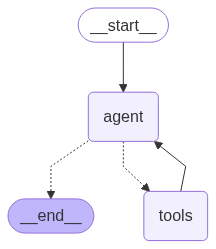

In [25]:
# Create agent 
agent = create_react_agent(
    model, 
    all_tools, 
    prompt=INSTRUCTIONS, 
    state_schema=DeepAgentState
)

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [26]:
from utils import format_messages

result = agent.invoke({
    "messages": [{"role": "user", "content": "Give me an overview of Model Context Protocol (MCP)."}],
})

format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Give me an overview of Model Context Protocol (MCP).                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you get a comprehensive overview of Model Context Protocol (MCP). Let me start by creating a research │
│ plan and then gathering information.                                                                            │
│                                                                                                                 │
│ 🔧 Tool Call: ls                                                                                                │
│    Args: {}                                                                                                     │
│    ID: toolu_01WywvBDKSQWuLmqxqoEnJFj                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_file                                                                                        │
│    Args: {                                                                                                      │
│   "file_path": "user_request.md",                                                                               │
│   "content": "# User Request\n\nGive me an overview of Model Context Protocol (MCP).\n\n## Research             │
│ Goal\nProvide a comprehensive overview covering:\n- What MCP is and its purpose\n- Key features and             │
│ capabilities\n- How it works technically\n- Use cases and applications\n- Current status and adoption"          │
│ }                                                                                                               │
│    ID: toolu_018xtgNuKMtMJBSRgRtiPVD7                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated file user_request.md                                                                                    │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, technical details, features, use │
│ cases, and current status",                                                                                     │
│       "status": "pending"                                                                                       │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "pending"                                                                                       │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_01ArBCm2KvAmEU4GjFKuKj1Y                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, technical       │
│ details, features, use cases, and current status', 'status': 'pending'}, {'content': 'Analyze research findings │
│ and provide comprehensive overview to user', 'status': 'pending'}]                                              │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Now let me delegate the research task to gather comprehensive information about MCP.                            │
│                                                                                                                 │
│ 🔧 Tool Call: task                                                                                              │
│    Args: {                                                                                                      │
│   "description": "Research Model Context Protocol (MCP) comprehensively. I need to understand: 1) What MCP is   │
│ and its fundamental purpose, 2) Key technical features and capabilities, 3) How it works architecturally, 4)    │
│ Main use cases and applications, 5) Current development status, adoption, and who created it. Please gather     │
│ detailed information from official sources, documentation, and recent developments.",                           │
│   "subagent_type": "research-agent"                                                                             │
│ }                                                                                                               │
│    ID: toolu_01FFbyBfvVmnLvZS7zUhLuri                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Based on my comprehensive research, here's what I found about the Model Context Protocol (MCP):                 │
│                                                                                                                 │
│ ## 1. What MCP Is and Its Fundamental Purpose                                                                   │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-standard framework introduced by Anthropic in November 2024.    │
│ Its fundamental purpose is to **standardize how AI systems integrate and share data with external tools and     │
│ data sources**. MCP aims to simplify the complex process of connecting AI applications to various external      │
│ systems, enhancing interoperability and making data access more seamless across different platforms.            │
│                                                                                                                 │
│ ## 2. Key Technical Features and Capabilities                                                                   │
│                                                                                                                 │
│ MCP offers several important technical features:                                                                │
│                                                                                                                 │
│ - **Open Standard Framework**: Provides a standardized approach to AI-tool integration                          │
│ - **Component Architecture**: Includes three main components:                                                   │
│   - **Tools**: External functions and capabilities AI can invoke                                                │
│   - **Resources**: Data sources and information repositories                                                    │
│   - **Prompts**: Standardized interaction templates                                                             │
│ - **Security Integration**: Incorporates OAuth 2.1 for secure authentication and authorization                  │
│ - **Complexity Reduction**: Significantly reduces the integration complexity that developers typically face     │
│ when connecting AI systems to external tools                                                                    │
│ - **Interoperability Focus**: Enables seamless connections between AI and various data sources                  │
│                                                                                                                 │
│ ## 3. Architectural Design                                                                                      │
│                                                                                                                 │
│ MCP uses a **client-server architecture** with three key components:                                            │
│                                                                                                                 │
│ - **Hosts**: The primary systems that coordinate interactions                                                   │
│ - **Clients**: AI applications that consume services and data                                                   │
│ - **Servers**: External tools and data sources that provide capabilities                                        │
│                                                                                                                 │
│ This architecture allows for standardized communication patterns between AI systems and external resources,     │
│ making integrations more predictable and maintainable.                                                          │
│                                                        

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: think_tool                                                                                        │
│    Args: {                                                                                                      │
│   "reflection": "The research agent provided excellent comprehensive information about MCP. I now have detailed │
│ information covering all the key aspects requested:\n\n1. \u2705 Definition and purpose - MCP is Anthropic's    │
│ open standard for AI-tool integration\n2. \u2705 Technical features - Component architecture, security,         │
│ interoperability\n3. \u2705 How it works - Client-server architecture with hosts, clients, servers\n4. \u2705   │
│ Use cases - Automation, voice integration, calendar management, etc.\n5. \u2705 Current status - Recent launch  │
│ (Nov 2024), adoption by major players\n\nThe information appears comprehensive and well-structured. I have      │
│ sufficient detail to provide a thorough overview to the user. I should now mark the research task as completed  │
│ and move to providing the final overview."                                                                      │
│ }                                                                                                               │
│    ID: toolu_018ndrTJm2hjYzkiwS92LRPV                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Reflection recorded: The research agent provided excellent comprehensive information about MCP. I now have      │
│ detailed information covering all the key aspects requested:                                                    │
│                                                                                                                 │
│ 1. ✅ Definition and purpose - MCP is Anthropic's open standard for AI-tool integration                         │
│ 2. ✅ Technical features - Component architecture, security, interoperability                                   │
│ 3. ✅ How it works - Client-server architecture with hosts, clients, servers                                    │
│ 4. ✅ Use cases - Automation, voice integration, calendar management, etc.                                      │
│ 5. ✅ Current status - Recent launch (Nov 2024), adoption by major players                                      │
│                                                                                                                 │
│ The information appears comprehensive and well-structured. I have sufficient detail to provide a thorough       │
│ overview to the user. I should now mark the research task as completed and move to providing the final          │
│ overview.                                                                                                       │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│ 🔧 Tool Call: write_todos                                                                                       │
│    Args: {                                                                                                      │
│   "todos": [                                                                                                    │
│     {                                                                                                           │
│       "content": "Research Model Context Protocol (MCP) - definition, purpose, technical details, features, use │
│ cases, and current status",                                                                                     │
│       "status": "completed"                                                                                     │
│     },                                                                                                          │
│     {                                                                                                           │
│       "content": "Analyze research findings and provide comprehensive overview to user",                        │
│       "status": "in_progress"                                                                                   │
│     }                                                                                                           │
│   ]                                                                                                             │
│ }                                                                                                               │
│    ID: toolu_019oBvHLh9rqftWVzkKnT5fr                                                                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, technical       │
│ details, features, use cases, and current status', 'status': 'completed'}, {'content': 'Analyze research        │
│ findings and provide comprehensive overview to user', 'status': 'in_progress'}]                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ # Model Context Protocol (MCP) Overview                                                                         │
│                                                                                                                 │
│ ## What is MCP?                                                                                                 │
│                                                                                                                 │
│ The **Model Context Protocol (MCP)** is an open-standard framework introduced by Anthropic in November 2024.    │
│ It's designed to **standardize how AI systems integrate and share data with external tools and data sources**,  │
│ addressing the complexity and fragmentation that currently exists in AI-tool integrations.                      │
│                                                                                                                 │
│ ## Core Purpose                                                                                                 │
│                                                                                                                 │
│ MCP aims to simplify the process of connecting AI applications to various external systems, enhancing           │
│ interoperability and making data access more seamless across different platforms. Instead of each AI system     │
│ requiring custom integrations for every tool or data source, MCP provides a unified approach.                   │
│                                                                                                                 │
│ ## Technical Architecture                                                                                       │
│                                                                                                                 │
│ MCP uses a **client-server architecture** with three main components:                                           │
│                                                                                                                 │
│ ### System Components:                                                                                          │
│ - **Hosts**: Primary systems that coordinate interactions                                                       │
│ - **Clients**: AI applications that consume services and data                                                   │
│ - **Servers**: External tools and data sources that provide capabilities                                        │
│                                                                                                                 │
│ ### Protocol Components:                                                                                        │
│ - **Tools**: External functions and capabilities that AI can invoke                                             │
│ - **Resources**: Data sources and information repositories                                                      │
│ - **Prompts**: Standardized interaction templates                                                               │
│                                                                                                                 │
│ ## Key Features                                                                                                 │
│                                                                                                                 │
│ - **Open Standard**: Provides a standardized approach accessible to all developers                              │
│ - **Security Integration**: Incorporates OAuth 2.1 for secure authentication and authorization                  │
│ - **Complexity Reduction**: Significantly reduces integration complexity for developers                         │
│ - **Interoperability**: Enables seamless connections be

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ Updated todo list to [{'content': 'Research Model Context Protocol (MCP) - definition, purpose, technical       │
│ details, features, use cases, and current status', 'status': 'completed'}, {'content': 'Analyze research        │
│ findings and provide comprehensive overview to user', 'status': 'completed'}]                                   │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I've provided you with a comprehensive overview of the Model Context Protocol (MCP). This covers everything     │
│ from its fundamental purpose as Anthropic's new open standard for AI-tool integration, through its technical    │
│ architecture and key features, to its current adoption status and potential significance in the AI ecosystem.   │
│                                                                                                                 │
│ Is there any particular aspect of MCP you'd like me to explore in more detail?                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Trace: 

https://smith.langchain.com/public/1df7a10e-1465-499c-a3e0-86c1d5429324/r

**TODO(Geoff)** Can show Studio. 

**TODO(Geoff)** Can discuss the deepagents package that rolls all this for you.

**TODO(Geoff)** Key point is that use of all these tools should be carefully prompted for each use-case!